# BASTI CMD FILES DATA PREPROCESSING

This notebook cleans-up the output file from BASTI CMD generation tool, generating a clean, comma separated file.

v2.0: included the limited magnitude factos for the CM diagram.

## Modules import

In [1]:
# MODULES IMPORT
import pandas as pd
import numpy as np

import numba

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns

sns.set(rc={'figure.figsize':(20.0, 10.0)})

## Configuration

In [2]:
# CONFIGURATION:
AUX_INPUT_FOLDER = "../data/Auxiliary_data/"
INPUT_FILE = "TFM_02_MW_2022-01-13-19-18-22_hdr.txt"
AUX_OUTPUT_FOLDER = "../data/Auxiliary_data/"

# PHOTOMETRY SYSTEM - UNCOMMENT THE CHOSEN ONE:
# Johnson-Cousins / Sloan / HST (ACS)
#PHOTO_SYS = "Johnson-Cousins" # Default
PHOTO_SYS = "Sloan"
#PHOTO_SYS = "HST (ACS)"

# AGE RANGES - Just a flag to assign to each star
AGE_RANGES = [1.0, 2.5e+9, 5.0e+9, 7.5e+9, 10.0e+9, 12.5e+9, 15.0e+9]
LOG_AGE_RANGES = [np.log10(i) for i in AGE_RANGES]

# METALLICITY RANGES - Just a flag to assign to each star
METAL_RANGES = [-3.0 -2.5, -2.0, -1.0, -0.5, 0.0, 0.5]

# LIMIT ABSOLUTE MAGNITUDE IN 'g' BAND FOR mg > +0.0 (v2.0)
MAX_G = 20000 # No efective limit
#MAX_G = 6.5
#MAX_G = 3.5
#MAX_G = 2.0
#MAX_G = 0.5
if MAX_G == 20000:
    OUTPUT_FILEMARK = "_NoLimit_"
else:
    OUTPUT_FILEMARK = "_" + str(MAX_G) + "_"
    
# CONSTANTS (DO NOT CHANGE)
#LOGG_SUN = 2.438694 # log10(274.596 m/s^2)
### WRONG VALUE, SEE SUMMARY ON 'NOTEBOOKETL_15_PoC_Low_mass_logg_Calculation.ipynb
LOGG_SUN = 4.438694 # log10(27459.6 m/s^2) # CORRECTED VALUE
TEFF_SUN = 5785 # K

In [3]:
AGE_RANGES

[1.0,
 2500000000.0,
 5000000000.0,
 7500000000.0,
 10000000000.0,
 12500000000.0,
 15000000000.0]

In [4]:
LOG_AGE_RANGES

[0.0,
 9.397940008672037,
 9.698970004336019,
 9.8750612633917,
 10.0,
 10.096910013008056,
 10.176091259055681]

In [5]:
# COLUMN NAMES - DO **NOT** CHANGE:
# Common columns
#( 1) star number (+ 2 if unres. binary)
#( 2) log(t) years
#( 3) [Fe/H]        
#( 4) value of evolving mass in Mo
#( 5) log(L/Lo)
#( 6) log(Teff)
#( 7) initial mass of unresolved secondary (in Mo) if different from 0.0
#( 8) Index variable star type (0 no var)
#( 9) log(P) in days of pulsating stars if different from 99.99
#(10...) <columns depending on the photometric system
COLUMN_MAPPING = {
        0: "star_number",
        1: "log(t[years])",
        2: "Metallicity[Fe/H]",
        3: "Mass[Mo]",
        4: "log(L/Lo)",
        5: "log(Teff[K])",
        6: "InitMassSec[Mo]",
        7: "VarStarIdx",
        8: "Pulsating_log(P[days])"
}
if PHOTO_SYS == "HST (ACS)":
    # Photometric columns:
    #(10) G_BP
    #(11) G
    #(12) G_RP
    #(13) G_RVS
    COL_IDX = [i for i in range(0, 13)]
    COLUMN_MAPPING[9] = "G_BP"
    COLUMN_MAPPING[10] = "G"
    COLUMN_MAPPING[11] = "G_RP"
    COLUMN_MAPPING[12] = "G_RVS"
elif PHOTO_SYS == "Sloan":
    # Photometric columns:
    #(10) u       
    #(11) g       
    #(12) r       
    #(13) i       
    #(14) z       
    COL_IDX = [i for i in range(0, 14)]
    COLUMN_MAPPING[9] = "u"
    COLUMN_MAPPING[10] = "g"
    COLUMN_MAPPING[11] = "r"
    COLUMN_MAPPING[12] = "i"
    COLUMN_MAPPING[13] = "z"    
elif PHOTO_SYS == "Johnson-Cousins":
    # Photometric columns:
    #(10) U       
    #(11) BX      
    #(12) B       
    #(13) V       
    #(14) R       
    #(15) I       
    #(16) J       
    #(17) H       
    #(18) K       
    #(19) L'      
    #(20) L       
    #(21) M       
    COL_IDX = [i for i in range(0, 21)]
    COLUMN_MAPPING[9] = "U"
    COLUMN_MAPPING[10] = "BX"
    COLUMN_MAPPING[11] = "B"
    COLUMN_MAPPING[12] = "V"
    COLUMN_MAPPING[13] = "R"
    COLUMN_MAPPING[14] = "I"
    COLUMN_MAPPING[15] = "J"
    COLUMN_MAPPING[16] = "H"
    COLUMN_MAPPING[17] = "K"
    COLUMN_MAPPING[18] = "L"
    COLUMN_MAPPING[19] = "L'"
    COLUMN_MAPPING[20] = "M"
else:
    # Default - Johnson-Cousins:
    # Photometric columns:
    #(10) U       
    #(11) BX      
    #(12) B       
    #(13) V       
    #(14) R       
    #(15) I       
    #(16) J       
    #(17) H       
    #(18) K       
    #(19) L'      
    #(20) L       
    #(21) M       
    COL_IDX = [i for i in range(0, 21)]
    COLUMN_MAPPING[9] = "U"
    COLUMN_MAPPING[10] = "BX"
    COLUMN_MAPPING[11] = "B"
    COLUMN_MAPPING[12] = "V"
    COLUMN_MAPPING[13] = "R"
    COLUMN_MAPPING[14] = "I"
    COLUMN_MAPPING[15] = "J"
    COLUMN_MAPPING[16] = "H"
    COLUMN_MAPPING[17] = "K"
    COLUMN_MAPPING[18] = "L"
    COLUMN_MAPPING[19] = "L'"
    COLUMN_MAPPING[20] = "M"


## Functions

In [6]:
def logg_star(logg_Sun, Teff_Sun, m_star_in_suns, log_L_star_in_suns, log_Teff_star):
    '''Calculates the log(g) of a star from other parameters of the star and the Sun's (refernce) values'''
    return logg_Sun + np.log10(m_star_in_suns) - log_L_star_in_suns + 4.0 * log_Teff_star - 4.0 * np.log10(Teff_Sun)
vector_logg_star = np.vectorize(logg_star)

In [7]:
@numba.jit
def logg_star_numba(logg_Sun, Teff_Sun, m_star_in_suns, log_L_star_in_suns, log_Teff_star):
    '''Calculates the log(g) of a star from other parameters of the star and the Sun's (refernce) values'''
    return logg_Sun + np.log10(m_star_in_suns) - log_L_star_in_suns + 4.0 * log_Teff_star - 4.0 * np.log10(Teff_Sun)
vector_logg_star = np.vectorize(logg_star)

## Data loading and cleaning

In [8]:
# DATA LOADING:
# Search for the first data line:
file_handler = open(AUX_INPUT_FOLDER + INPUT_FILE, 'r')
first_data = -1
is_data = False
while is_data == False:
    first_data += 1
    # Get next line from file
    line = file_handler.readline()
    if line[0] == '#':
        # It is still a comment line
        pass
    else:
        # A data line was found
        is_data = True
file_handler.close()
print("First data line found at position %d" %first_data)

First data line found at position 32


In [9]:
# Data loading and cleaning
df = pd.read_csv(AUX_INPUT_FOLDER + INPUT_FILE, sep=' ', skiprows=first_data, names=COL_IDX, skipinitialspace=True)
df.rename(columns=COLUMN_MAPPING, inplace=True)
df.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,g,r,i,z
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,14.4492,12.5954,11.7931,11.3269
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,14.3751,12.5610,11.7760,11.3214
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,10.7053,9.2975,8.7596,8.4500
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,10.4675,9.1732,8.6722,8.3836
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,12.0461,10.4433,9.8380,9.5020


In [10]:
df.shape

(264732, 14)

In [11]:
df.columns

Index(['star_number', 'log(t[years])', 'Metallicity[Fe/H]', 'Mass[Mo]',
       'log(L/Lo)', 'log(Teff[K])', 'InitMassSec[Mo]', 'VarStarIdx',
       'Pulsating_log(P[days])', 'u', 'g', 'r', 'i', 'z'],
      dtype='object')

## Data processing

### Colour indices

In [12]:
if PHOTO_SYS == "Johnson-Cousins":
    df['U-B'] = df['U'] - df['B']
    df['B-V'] = df['B'] - df['V']
    #df['B-R'] = df['B'] - df['R']
    #df['B-I'] = df['B'] - df['I']
    df['V-R'] = df['V'] - df['R']
    #df['V-I'] = df['V'] - df['I']
    df['R-I'] = df['R'] - df['I']
elif PHOTO_SYS == "Sloan":
    # TODO: complete with some other color indices for Sloan.
    df['u-g'] = df['u'] - df['g']
    df['g-r'] = df['g'] - df['r']
    #df['g-i'] = df['g'] - df['i']
    df['r-i'] = df['r'] - df['i']
    df['i-z'] = df['i'] - df['z']
elif PHOTO_SYS == "HST (ACS)":
    # TODO: color indices for HST (ACS).
    pass
else:
    print("Invalid photometric option!")
    pass


In [13]:
df.columns

Index(['star_number', 'log(t[years])', 'Metallicity[Fe/H]', 'Mass[Mo]',
       'log(L/Lo)', 'log(Teff[K])', 'InitMassSec[Mo]', 'VarStarIdx',
       'Pulsating_log(P[days])', 'u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i',
       'i-z'],
      dtype='object')

 ### Value of `log(g)` for each star:

In [14]:
df.shape

(264732, 18)

In [15]:
###### TRIAL WITH LESS COLUMNS
df_small = df.iloc[:2000, ].copy()
df_small.shape

(2000, 18)

In [16]:
%%time
# Just pandas:
df_small['log_g'] = df_small.apply(
    lambda x: vector_logg_star(LOGG_SUN, TEFF_SUN, df_small['Mass[Mo]'], df_small['log(L/Lo)'], df_small['log(Teff[K])']),
    axis=1)
df_small.head()
#df['fee'] = df.apply(lambda x: feez(x['total_rides'], x['plan_name']), axis=1)

CPU times: total: 9.64 s
Wall time: 9.63 s


,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,g,r,i,z,u-g,g-r,r-i,i-z,log_g
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,14.4492,12.5954,11.7931,11.3269,3.6451,1.8538,0.8023,0.4662,"[5.296607044789548, 5.309206240802235, 5.02401..."
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,14.3751,12.5610,11.7760,11.3214,3.5654,1.8141,0.7850,0.4546,"[5.296607044789548, 5.309206240802235, 5.02401..."
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,10.7053,9.2975,8.7596,8.4500,2.4401,1.4078,0.5379,0.3096,"[5.296607044789548, 5.309206240802235, 5.02401..."
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,10.4675,9.1732,8.6722,8.3836,2.3044,1.2943,0.5010,0.2886,"[5.296607044789548, 5.309206240802235, 5.02401..."
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,12.0461,10.4433,9.8380,9.5020,2.7113,1.6028,0.6053,0.3360,"[5.296607044789548, 5.309206240802235, 5.02401..."


In [17]:
%%time
# With numba:
df_small['log_g'] = df_small.apply(
    lambda x: logg_star_numba(LOGG_SUN, TEFF_SUN,
                              df_small['Mass[Mo]'].to_numpy(),
                              df_small['log(L/Lo)'].to_numpy(),
                              df_small['log(Teff[K])'].to_numpy()),
    axis=1)
df_small.head()

CPU times: total: 609 ms
Wall time: 645 ms


,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,g,r,i,z,u-g,g-r,r-i,i-z,log_g
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,14.4492,12.5954,11.7931,11.3269,3.6451,1.8538,0.8023,0.4662,"[5.296607044789548, 5.309206240802235, 5.02401..."
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,14.3751,12.5610,11.7760,11.3214,3.5654,1.8141,0.7850,0.4546,"[5.296607044789548, 5.309206240802235, 5.02401..."
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,10.7053,9.2975,8.7596,8.4500,2.4401,1.4078,0.5379,0.3096,"[5.296607044789548, 5.309206240802235, 5.02401..."
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,10.4675,9.1732,8.6722,8.3836,2.3044,1.2943,0.5010,0.2886,"[5.296607044789548, 5.309206240802235, 5.02401..."
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,12.0461,10.4433,9.8380,9.5020,2.7113,1.6028,0.6053,0.3360,"[5.296607044789548, 5.309206240802235, 5.02401..."


In [18]:
%%time
# We try to do the calculation sequentially, instead of using a complex function
#def logg_star(logg_Sun, Teff_Sun, m_star_in_suns, log_L_star_in_suns, log_Teff_star):
#    '''Calculates the log(g) of a star from other parameters of the star and the Sun's (refernce) values'''
#    return logg_Sun + np.log10(m_star_in_suns) + log_L_star_in_suns - 4.0 * log_Teff_star + 4.0 * np.log10(Teff_Sun)
df['log_g'] = -4.0 * np.log10(TEFF_SUN)

CPU times: total: 0 ns
Wall time: 998 µs


In [19]:
%%time
df['log_g'] = df['log_g'] + 4.0 * df['log(Teff[K])']

CPU times: total: 0 ns
Wall time: 2.99 ms


In [20]:
%%time
df['log_g'] = df['log_g'] - df['log(L/Lo)']

CPU times: total: 0 ns
Wall time: 2 ms


In [21]:
%%time
df['log_g'] = df['log_g'] + np.log10(df['Mass[Mo]'])

CPU times: total: 0 ns
Wall time: 3.99 ms


In [22]:
%%time
df['log_g'] = df['log_g'] + LOGG_SUN

CPU times: total: 0 ns
Wall time: 997 µs


In [23]:
df.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,g,r,i,z,u-g,g-r,r-i,i-z,log_g
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,14.4492,12.5954,11.7931,11.3269,3.6451,1.8538,0.8023,0.4662,5.296607
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,14.3751,12.5610,11.7760,11.3214,3.5654,1.8141,0.7850,0.4546,5.309206
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,10.7053,9.2975,8.7596,8.4500,2.4401,1.4078,0.5379,0.3096,5.024010
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,10.4675,9.1732,8.6722,8.3836,2.3044,1.2943,0.5010,0.2886,5.057169
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,12.0461,10.4433,9.8380,9.5020,2.7113,1.6028,0.6053,0.3360,5.170441


In [24]:
df['log_g'].describe()

count    264732.000000
mean          5.070244
std           0.220097
min           0.665406
25%           5.003494
50%           5.110949
75%           5.214531
max           5.385102
Name: log_g, dtype: float64

In [25]:
df['Mass[Mo]'].describe()

count    264732.000000
mean          0.240257
std           0.225625
min           0.100000
25%           0.122900
50%           0.163400
75%           0.261200
max           6.819200
Name: Mass[Mo], dtype: float64

In [26]:
df['log(L/Lo)'].describe()

count    264732.000000
mean         -2.188406
std           0.698589
min          -3.087300
25%          -2.663200
50%          -2.362650
75%          -1.945400
max           3.401800
Name: log(L/Lo), dtype: float64

In [27]:
df['log(Teff[K])'].describe()

count    264732.000000
mean          3.551418
std           0.068866
min           3.438200
25%           3.507600
50%           3.541300
75%           3.576100
max           4.308900
Name: log(Teff[K]), dtype: float64

In [28]:
np.log10(TEFF_SUN)

3.7623033632877685

In [29]:
# Check Sun:
#def logg_star(logg_Sun, Teff_Sun, m_star_in_suns, log_L_star_in_suns, log_Teff_star):
#    '''Calculates the log(g) of a star from other parameters of the star and the Sun's (refernce) values'''
#    return logg_Sun + np.log10(m_star_in_suns) + log_L_star_in_suns - 4.0 * log_Teff_star + 4.0 * np.log10(Teff_Sun)
logg_star(LOGG_SUN, TEFF_SUN, 1.0, 0.0, np.log10(5785))

4.438694

In [30]:
LOGG_SUN

4.438694

### Add effective temperature

In [31]:
df['Teff'] = 10.0 ** df['log(Teff[K])']

### Add raw years values

In [32]:
df['Age [Gyr]'] = df['log(t[years])'].map(lambda x: 10**x / 1.0e+9)
df.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,...,r,i,z,u-g,g-r,r-i,i-z,log_g,Teff,Age [Gyr]
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,...,12.5954,11.7931,11.3269,3.6451,1.8538,0.8023,0.4662,5.296607,3224.036872,8.402622
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,...,12.5610,11.7760,11.3214,3.5654,1.8141,0.7850,0.4546,5.309206,3264.374675,8.851255
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,...,9.2975,8.7596,8.4500,2.4401,1.4078,0.5379,0.3096,5.024010,3867.229981,8.201037
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,...,9.1732,8.6722,8.3836,2.3044,1.2943,0.5010,0.2886,5.057169,3961.867984,9.244008
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,...,10.4433,9.8380,9.5020,2.7113,1.6028,0.6053,0.3360,5.170441,3707.660840,8.308000


### Age ranges

In [33]:
df['Age Range [Gyr]'] = ""
df['ID Age Range'] = -1
sorted_age = []
for i in range(0, len(LOG_AGE_RANGES) - 1):
    if i == 0:
        range_id = "< " + str(AGE_RANGES[i + 1] / 1.0e+9) + " Gyr"
    elif i == len(LOG_AGE_RANGES) - 2:
        range_id = "> " + str(AGE_RANGES[i] / 1.0e+9) + " Gyr"
    else:
        range_id = "from " + str(AGE_RANGES[i] / 1.0e+9) + " to " + str(AGE_RANGES[i + 1] / 1.0e+9) + " Gyr"
    #print("i = %d" %i)
    #print("range_id = %s" %range_id)
    #print("RANGE (Gyr): %.2f - %.2f\n" %(AGE_RANGES[i] / 1.0e+9, AGE_RANGES[i+1] / 1.0e+9))
    sorted_age.append(range_id)
    df.loc[(df['log(t[years])'] >= LOG_AGE_RANGES[i]) & (df['log(t[years])'] < LOG_AGE_RANGES[i+1]),
           'Age Range [Gyr]'] = range_id    
    df.loc[(df['log(t[years])'] >= LOG_AGE_RANGES[i]) & (df['log(t[years])'] < LOG_AGE_RANGES[i+1]),
           'ID Age Range'] = "Age_" + str(i)
# Establish an order to the column:
df['Age Range [Gyr]'] = pd.Categorical(df['Age Range [Gyr]'],
                                       categories=sorted_age,
                                       ordered=True)
df.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,...,z,u-g,g-r,r-i,i-z,log_g,Teff,Age [Gyr],Age Range [Gyr],ID Age Range
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,...,11.3269,3.6451,1.8538,0.8023,0.4662,5.296607,3224.036872,8.402622,from 7.5 to 10.0 Gyr,Age_3
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,...,11.3214,3.5654,1.8141,0.7850,0.4546,5.309206,3264.374675,8.851255,from 7.5 to 10.0 Gyr,Age_3
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,...,8.4500,2.4401,1.4078,0.5379,0.3096,5.024010,3867.229981,8.201037,from 7.5 to 10.0 Gyr,Age_3
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,...,8.3836,2.3044,1.2943,0.5010,0.2886,5.057169,3961.867984,9.244008,from 7.5 to 10.0 Gyr,Age_3
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,...,9.5020,2.7113,1.6028,0.6053,0.3360,5.170441,3707.660840,8.308000,from 7.5 to 10.0 Gyr,Age_3


### Metallicity ranges

In [34]:
df['Metallicity Range [Fe/H]'] = ""
df['ID Metallicity Range'] = -1
sorted_metallicity = []
for i in range(0, len(METAL_RANGES) - 1):
    if i == 0:
        range_id = "< " + str(METAL_RANGES[i + 1]) + " [Fe/H]"
    elif i == len(METAL_RANGES) - 2:
        range_id = "> " + str(METAL_RANGES[i]) + " [Fe/H]"
    else:
        range_id = "from " + str(METAL_RANGES[i]) + " to " + str(METAL_RANGES[i + 1]) + " [Fe/H]"
    #print("i = %d" %i)
    #print("range_id = %s" %range_id)
    #print("RANGE ([Fe/H]): %.2f - %.2f\n" %(METAL_RANGE[i], METAL_RANGE[i+1]))
    sorted_metallicity.append(range_id)
    df.loc[(df['Metallicity[Fe/H]'] >= METAL_RANGES[i]) & (df['Metallicity[Fe/H]'] < METAL_RANGES[i+1]),
           'Metallicity Range [Fe/H]'] = range_id
    df.loc[(df['Metallicity[Fe/H]'] >= METAL_RANGES[i]) & (df['Metallicity[Fe/H]'] < METAL_RANGES[i+1]),
           'ID Metallicity Range'] = "Met_" + str(i)
# Reorder the column:
df['Metallicity Range [Fe/H]'] = pd.Categorical(df['Metallicity Range [Fe/H]'],
                                                categories=sorted_metallicity,
                                                ordered=True)

df.head()

,star_number,log(t[years]),Metallicity[Fe/H],Mass[Mo],log(L/Lo),log(Teff[K]),InitMassSec[Mo],VarStarIdx,Pulsating_log(P[days]),u,...,g-r,r-i,i-z,log_g,Teff,Age [Gyr],Age Range [Gyr],ID Age Range,Metallicity Range [Fe/H],ID Metallicity Range
0,1,9.924415,-1.4575,0.1090,-2.8361,3.5084,0.0928,0,99.99,18.0943,...,1.8538,0.8023,0.4662,5.296607,3224.036872,8.402622,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
1,2,9.947005,-1.2202,0.1081,-2.8307,3.5138,0.0867,0,99.99,17.9405,...,1.8141,0.7850,0.4546,5.309206,3264.374675,8.851255,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
2,4,9.913869,-0.7478,0.2711,-1.8518,3.5874,0.2057,0,99.99,13.1454,...,1.4078,0.5379,0.3096,5.024010,3867.229981,8.201037,from 7.5 to 10.0 Gyr,Age_3,from -1.0 to -0.5 [Fe/H],Met_2
3,6,9.965860,-1.0048,0.2449,-1.8871,3.5979,0.2222,0,99.99,12.7719,...,1.2943,0.5010,0.2886,5.057169,3961.867984,9.244008,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1
4,8,9.919496,-1.4860,0.1656,-2.2855,3.5691,0.1339,0,99.99,14.7574,...,1.6028,0.6053,0.3360,5.170441,3707.660840,8.308000,from 7.5 to 10.0 Gyr,Age_3,from -2.0 to -1.0 [Fe/H],Met_1


### Check results

#### Check age range preprocessing

In [35]:
# Count occurrences:
df[['Age Range [Gyr]', 'star_number']].groupby(by='Age Range [Gyr]').count()

,star_number
Age Range [Gyr],
< 2.5 Gyr,90446
from 2.5 to 5.0 Gyr,79188
from 5.0 to 7.5 Gyr,18980
from 7.5 to 10.0 Gyr,76118
from 10.0 to 12.5 Gyr,0
> 12.5 Gyr,0


<AxesSubplot: xlabel='Age Range [Gyr]', ylabel='Age [Gyr]'>

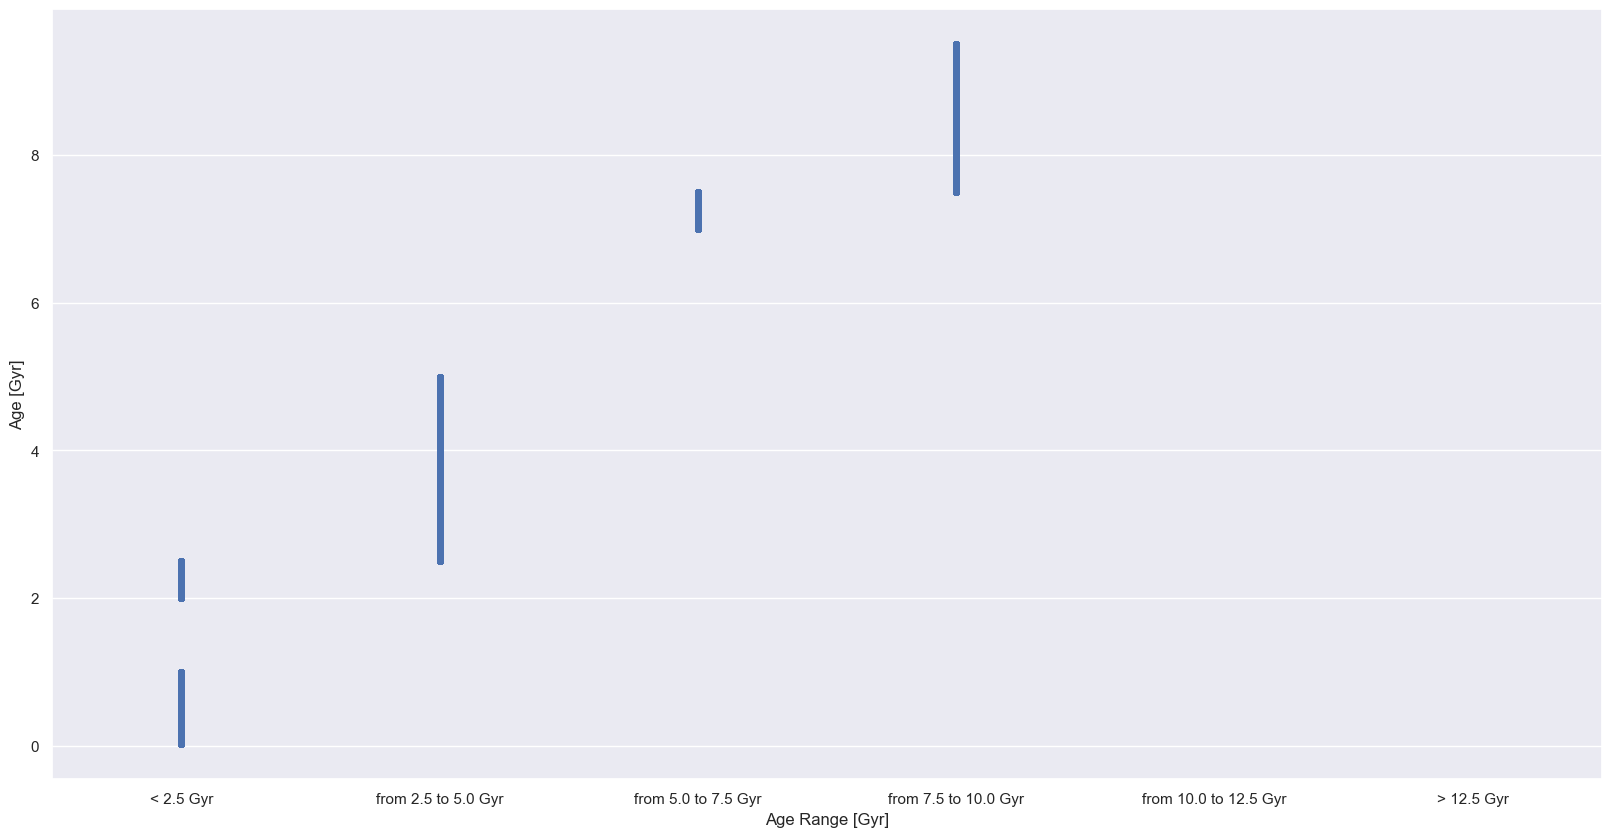

In [36]:
# Check Age range preprocessing
#plt.scatter(df['log(t[years])'], df['Age Range [Gyr]'])
sns.stripplot(data = df,
              x='Age Range [Gyr]', y='Age [Gyr]', 
              order=sorted_age, jitter=False)

#### Check metallicity range preprocessing

In [37]:
# Count occurrences:
df[['Metallicity Range [Fe/H]', 'star_number']].groupby(by='Metallicity Range [Fe/H]').count()

,star_number
Metallicity Range [Fe/H],
< -2.0 [Fe/H],4080
from -2.0 to -1.0 [Fe/H],67726
from -1.0 to -0.5 [Fe/H],76580
from -0.5 to 0.0 [Fe/H],78594
> 0.0 [Fe/H],37739


<AxesSubplot: xlabel='Metallicity Range [Fe/H]', ylabel='Metallicity[Fe/H]'>

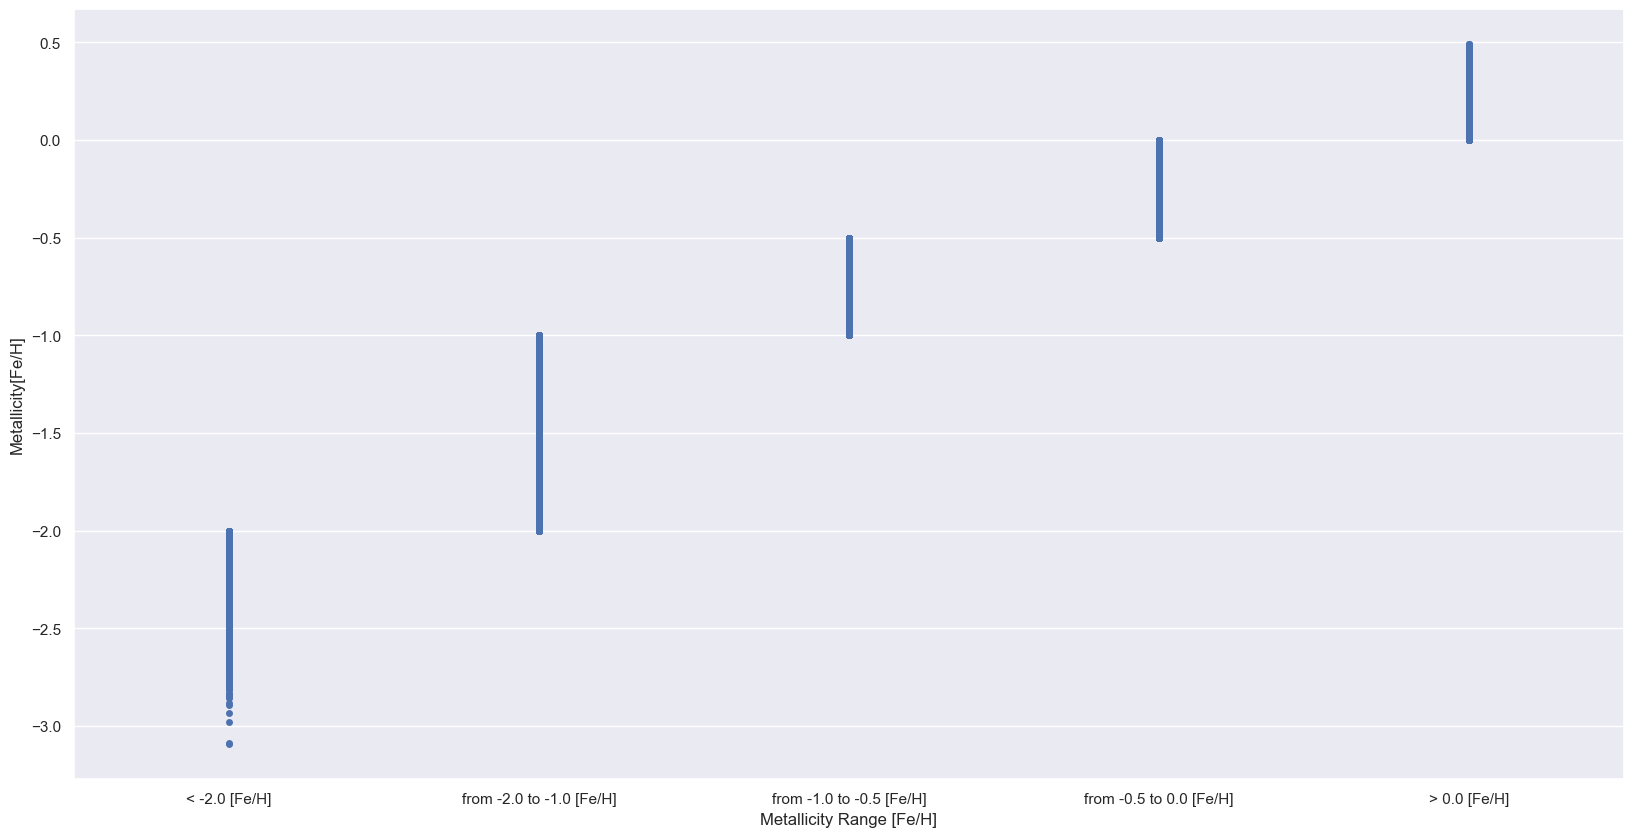

In [39]:
# Check Metallicity range preprocessing
#plt.scatter(df['Metallicity[Fe/H])'], df['Metallicity Range [Fe/H]'])
sns.stripplot(data = df,
              x='Metallicity Range [Fe/H]', y='Metallicity[Fe/H]', 
              order=sorted_metallicity, jitter=False)

#### Check Metallicity vs Age (sample stratified by Age Range)

<AxesSubplot: xlabel='Age [Gyr]', ylabel='Metallicity[Fe/H]'>

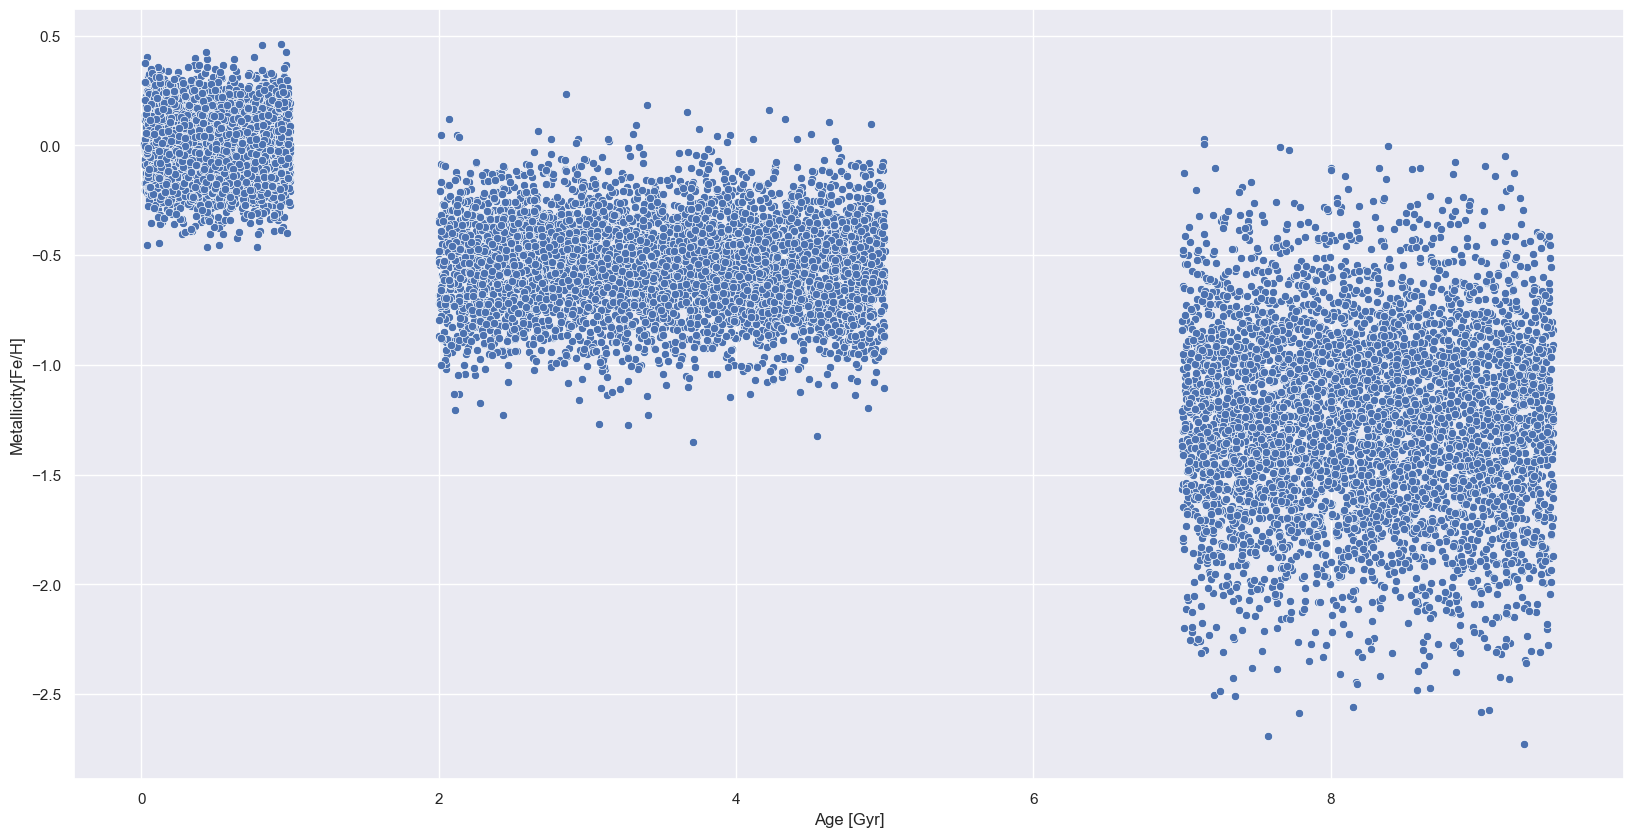

In [40]:
_, x_age, _, y_met = train_test_split(df['Age [Gyr]'], df['Metallicity[Fe/H]'],
                                      test_size=0.05, stratify=df['Age Range [Gyr]'])

#sns.stripplot(data = df, x=x_age, y=y_met, jitter=False)
sns.scatterplot(data = df, x=x_age, y=y_met)


#### Check Age vs Metallicity (sample stratified by Metallicity Range)

<AxesSubplot: xlabel='Metallicity[Fe/H]', ylabel='Age [Gyr]'>

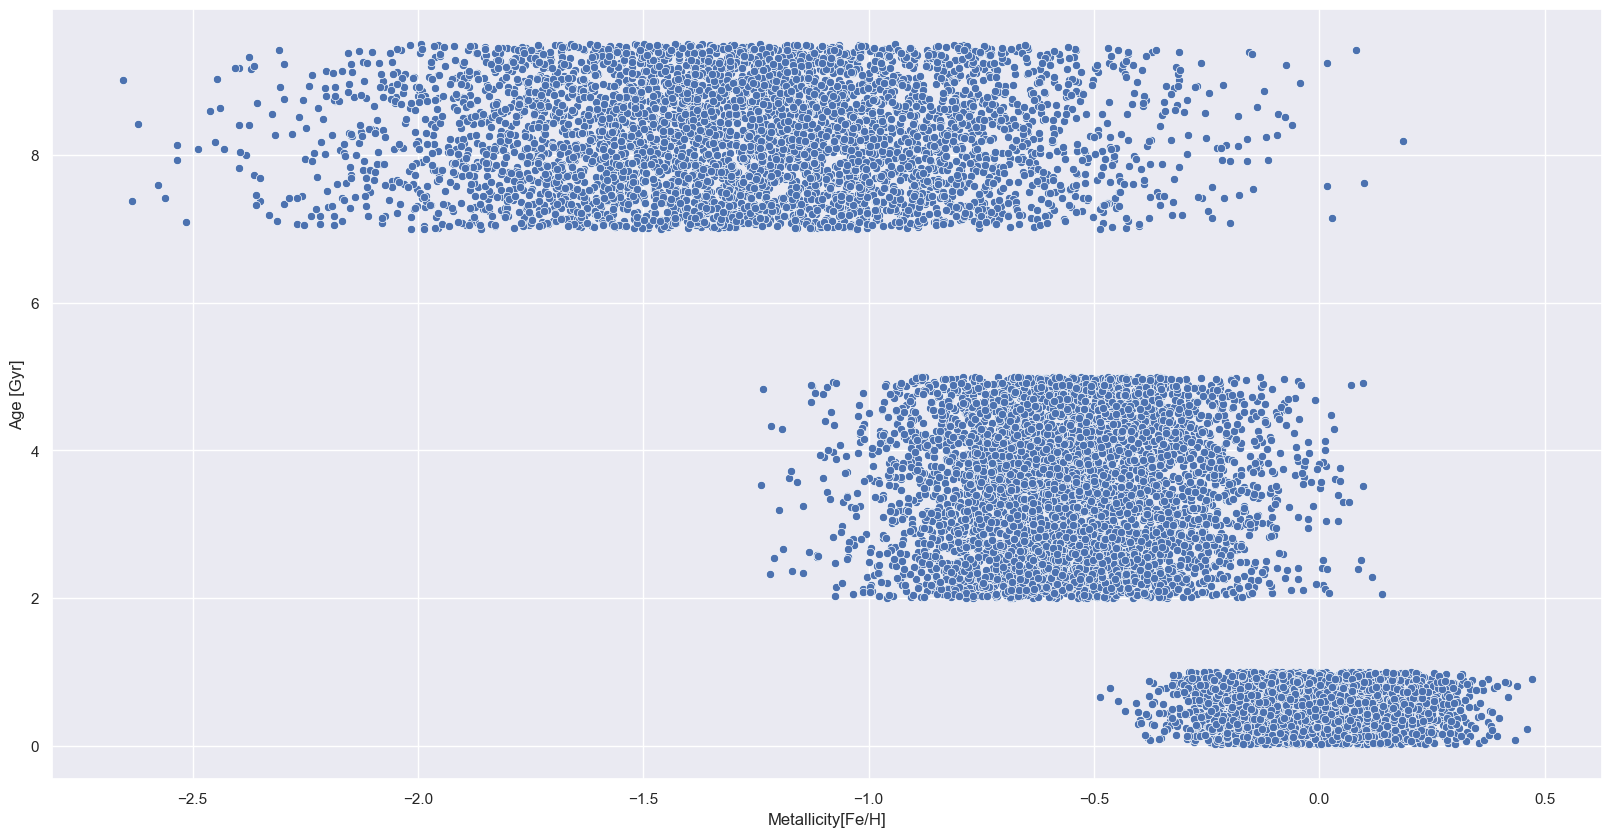

In [41]:
_, x_met, _, y_age = train_test_split(df.dropna()['Metallicity[Fe/H]'], df.dropna()['Age [Gyr]'],
                                      test_size=0.05, stratify=df.dropna()['Metallicity Range [Fe/H]'])

#sns.stripplot(data = df, x=x_age, y=y_met, jitter=False)
sns.scatterplot(data = df, x=x_met, y=y_age)


### Setting up the distance limit for the CMD (only for 'g' band of Sloan photometric system)

In [42]:
df.columns

Index(['star_number', 'log(t[years])', 'Metallicity[Fe/H]', 'Mass[Mo]',
       'log(L/Lo)', 'log(Teff[K])', 'InitMassSec[Mo]', 'VarStarIdx',
       'Pulsating_log(P[days])', 'u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i',
       'i-z', 'log_g', 'Teff', 'Age [Gyr]', 'Age Range [Gyr]', 'ID Age Range',
       'Metallicity Range [Fe/H]', 'ID Metallicity Range'],
      dtype='object')

In [43]:
try:
    df = df[df['g'] <= MAX_G]
except Exception as e:
    print("--- Some error happened. Remember that this part is only valid for 'Sloan' photometric system")
    print("--- Eror details: %s", e)

## Store the cleaned-up file

In [44]:
df.to_csv(AUX_OUTPUT_FOLDER + "ETLed_" + OUTPUT_FILEMARK + INPUT_FILE[:-4] + ".csv", sep=',', decimal='.', index=False)